In [10]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

from dataset import PatchDataset
from model import PatchClassifier, ModelHandler
from rel_cam.model import PatchClassifier as PatchClassifierRS
from rel_cam.utils import tensor2image
import config
import utils

from pytorch_grad_cam import (GradCAM , HiResCAM, GradCAMPlusPlus, 
    AblationCAM, XGradCAM ,LayerCAM, FullGrad, EigenCAM)
from utils import ScoreCAM, show_crop_cam_on_image

from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

from PIL import Image
import matplotlib.pyplot as plt

import lovely_tensors as lt

In [11]:
layer_idx = 3
INF_DICE = 88.24

model = PatchClassifier(
    features_only=config.FEATURES_ONLY, 
    out_classes=config.NUM_CLASSES,
    freeze_encoder=config.FREEZE_ENCODER,
)

ref_dataset = PatchDataset(config.DATA_DIR, config.ATF, preproc=False, augment=False)
dataset = PatchDataset(config.DATA_DIR, config.ATF, preproc=True, augment=False)

mh = ModelHandler(model)
mh.load(os.path.join(config.MODEL_FOLDER, f'{config.CONFIG_ID}_{INF_DICE}.pt'))
mh.model.requires_grad_(True)
mh.model.eval().cuda()

target_layers = eval(f"[mh.model.model.layer{layer_idx}[-1]]")

In [13]:
methods = [
    dict(method=GradCAM, method_str='GradCAM'),
    dict(method=HiResCAM, method_str='HiResCAM'),
    dict(method=GradCAMPlusPlus, method_str='GradCAM++'),
    dict(method=AblationCAM, method_str='AblationCAM'),
    dict(method=XGradCAM, method_str='XGradCAM'),
    dict(method=EigenCAM, method_str='EigenCAM'),
    dict(method=FullGrad, method_str='FullGrad'),
    dict(method=LayerCAM, method_str='LayerCAM'),
]

In [14]:
%%capture
# RelCAM and ScoreCAM specific model
model_rs = PatchClassifierRS(out_classes=config.NUM_CLASSES).model
model_rs.load_state_dict(torch.load('./rel_cam/models/resnet18_imagenet_aug_90.64.pt'))
model_rs.requires_grad_(True)
model_rs = model_rs.eval().cuda()
target_layer_name = f'layer{layer_idx}'

value = dict()
def forward_hook(module, input, output):
    value['activations'] = output
def backward_hook(module, input, output):
    value['gradients'] = output[0]

target_layer_rs = eval(f"model_rs.{target_layer_name}")
target_layer_rs.register_forward_hook(forward_hook)
target_layer_rs.register_backward_hook(backward_hook)

In [15]:
classes = list(dataset.class_to_idx.keys())
class_imgs = {}

np.random.seed(42)
for class_name in classes:
    class_idx = ref_dataset.class_to_idx[class_name]
    class_img_idx = np.random.choice(np.where(np.asarray(dataset.targets) == class_idx)[0])

    ref_img = Image.open(ref_dataset.imgs[class_img_idx]).resize(config.INPUT_SIZE)
    img_norm_resized = np.asarray(ref_img) / 255.0
    tensor_in = dataset[class_img_idx][0].unsqueeze(0).requires_grad_(True).cuda()
    target_class = int(dataset[class_img_idx][1])
    tensor_label = dataset[class_img_idx][1].cuda()
    class_out_target = [ClassifierOutputTarget(int(dataset[class_img_idx][1]))]

    class_imgs[class_name] = (ref_img, img_norm_resized, tensor_in, target_class, class_out_target)

In [16]:
results = {}
for class_name in classes:
    cam_imgs = []
    ref_img, img_norm_resized, tensor_in, target_class, class_out_target = class_imgs[class_name]
    for method in methods:
        cam = method['method'](model=mh.model, target_layers=target_layers, use_cuda=True)
        grayscale_cam = cam(input_tensor=tensor_in, targets=class_out_target)
        grayscale_cam = grayscale_cam[0, :]

        visualization_crop = show_crop_cam_on_image(img_norm_resized, grayscale_cam)
        visualization_hm = show_cam_on_image(img_norm_resized, grayscale_cam, use_rgb=True) / 255.0        
        visualization = np.hstack((visualization_crop, visualization_hm))
        cam_imgs.append((visualization, f"{str(method['method_str'])}"))

    ### Relevance CAM
    Rel_CAM_tensor, output = model_rs(tensor_in, target_layer_name, [target_class])
    Rel_CAM = tensor2image(Rel_CAM_tensor)

    visualization_crop = show_crop_cam_on_image(img_norm_resized, Rel_CAM)
    visualization_hm = show_cam_on_image(img_norm_resized, Rel_CAM, use_rgb=True) / 255.0        
    visualization = np.hstack((visualization_crop, visualization_hm))
    cam_imgs.append((visualization, f"RelCAM"))

    ### Score CAM
    Score_CAM_class = ScoreCAM(model_rs, target_layer_rs)
    score_map, _ = Score_CAM_class(tensor_in, class_idx=target_class)
    score_map = score_map.squeeze().detach().cpu().numpy()

    visualization_crop = show_crop_cam_on_image(img_norm_resized, score_map)
    visualization_hm = show_cam_on_image(img_norm_resized, score_map, use_rgb=True) / 255.0        
    visualization = np.hstack((visualization_crop, visualization_hm))
    cam_imgs.append((visualization, f"ScoreCAM"))

    results[class_name] = (ref_img, target_class, cam_imgs)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 77.98it/s]


100%|██████████| 8/8 [00:00<00:00, 94.31it/s]


100%|██████████| 8/8 [00:00<00:00, 93.89it/s]


100%|██████████| 8/8 [00:00<00:00, 94.55it/s]


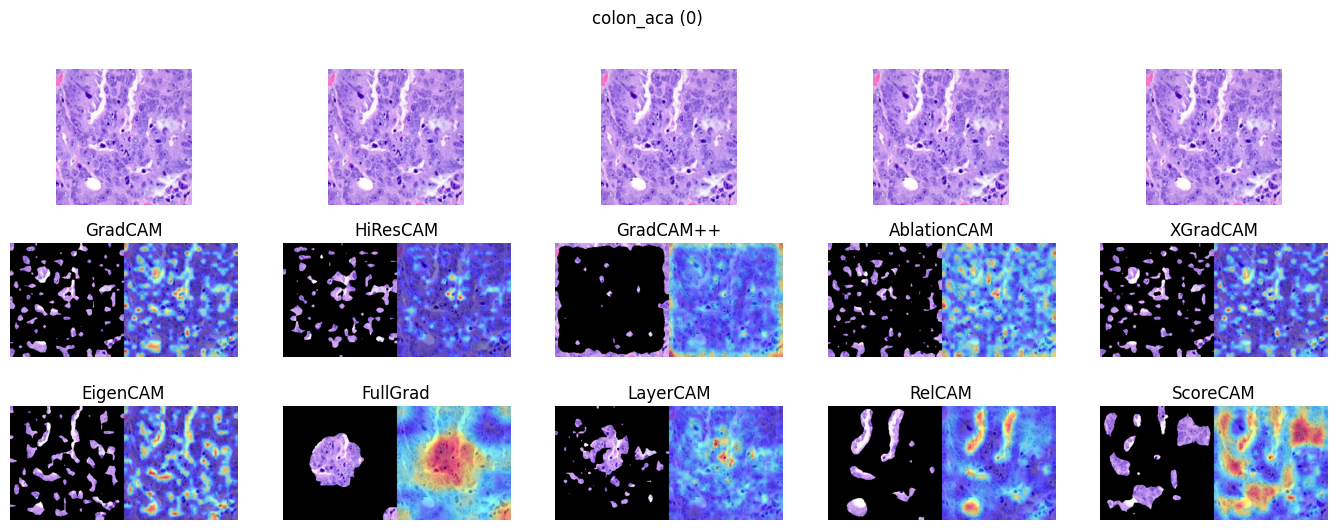

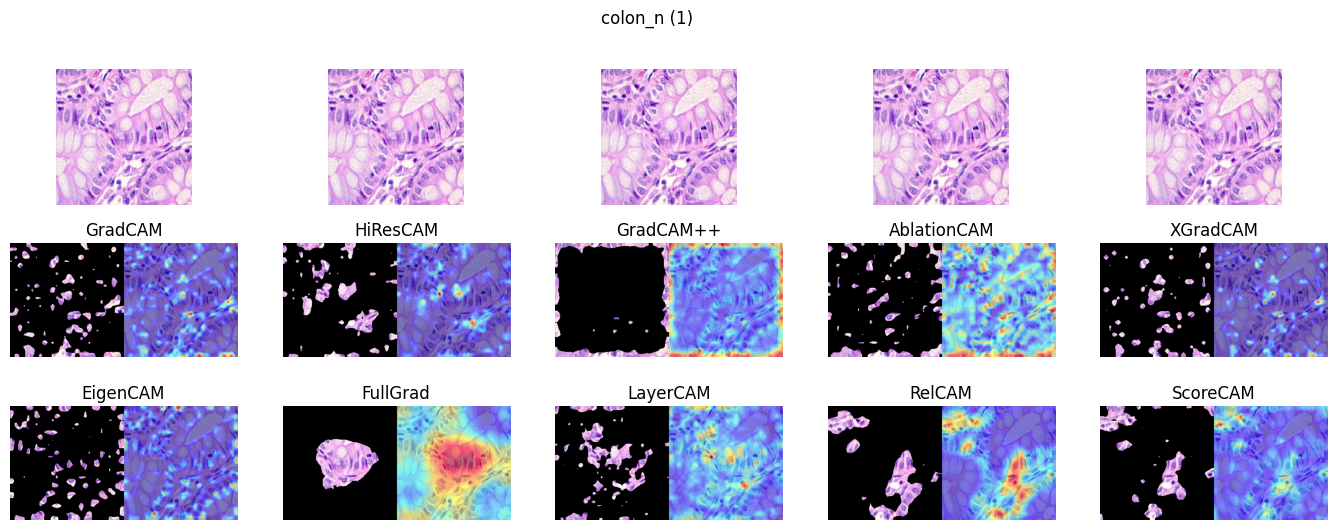

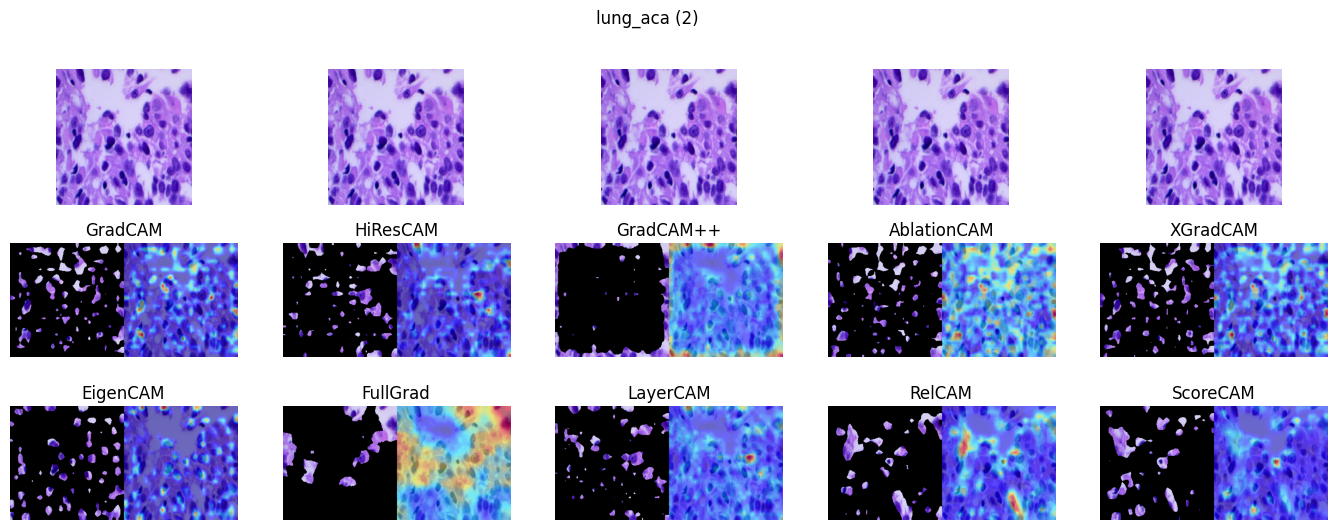

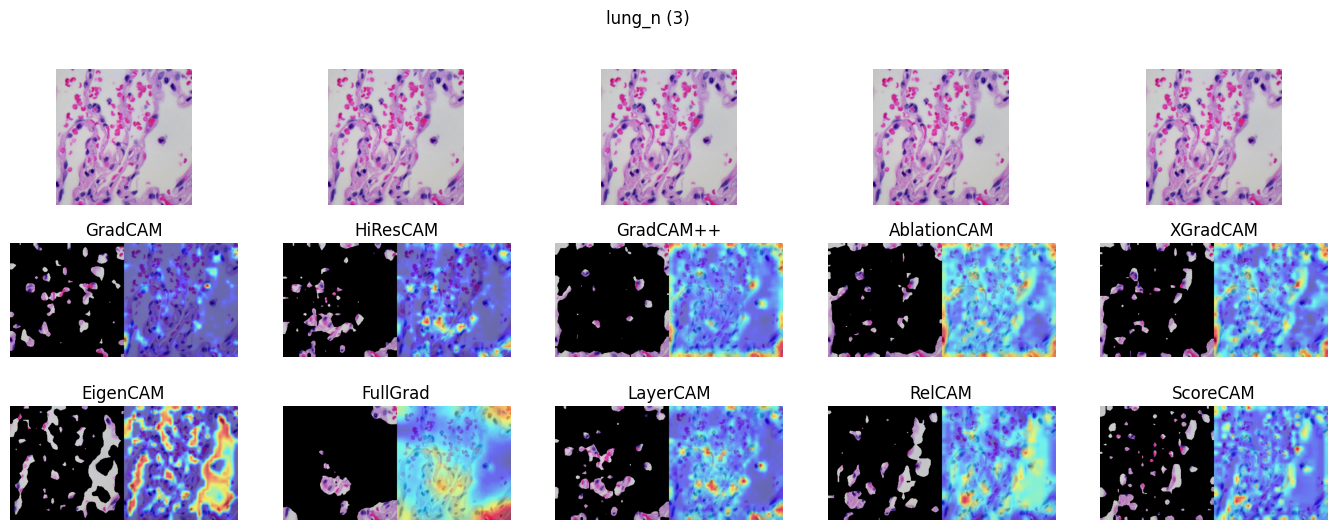

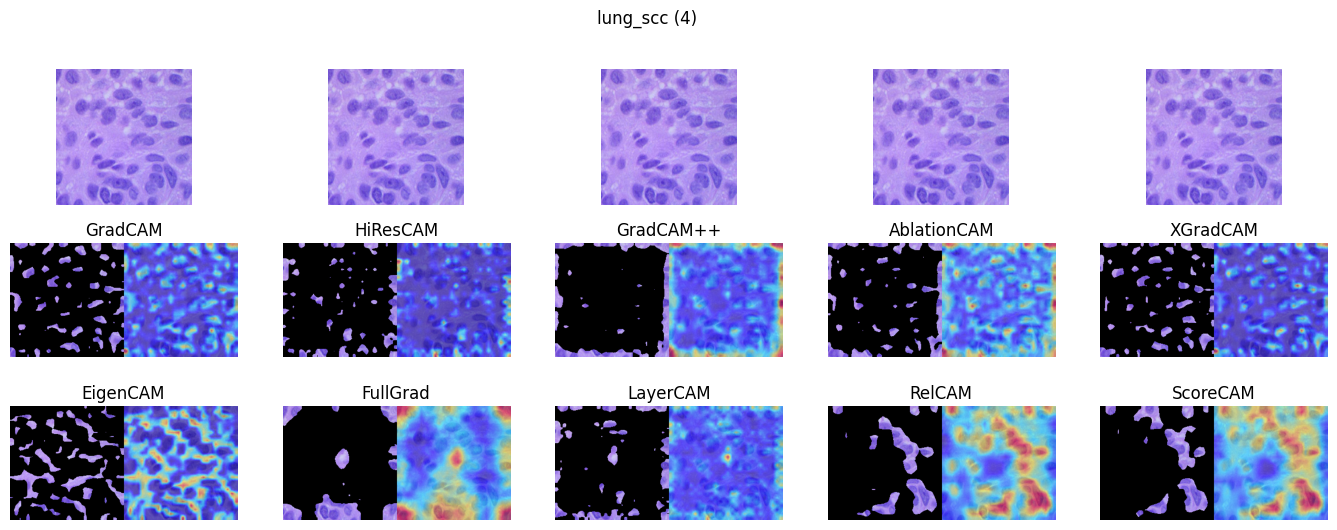

In [ ]:
for class_name in classes:
    ref_img, target_class, cam_imgs = results[class_name]
    fig, ax = plt.subplots(3, 5, figsize=(17, 6))
    fig.suptitle(f"{class_name} ({target_class})")
    for i in range(5):
        ax[0, i].imshow(ref_img)
        ax[0, i].axis('off')

        ax[1, i].imshow(cam_imgs[i][0])
        ax[1, i].set_title(cam_imgs[i][1])
        ax[1, i].axis('off')

        ax[2, i].imshow(cam_imgs[i+5][0])
        ax[2, i].set_title(cam_imgs[i+5][1])
        ax[2, i].axis('off')

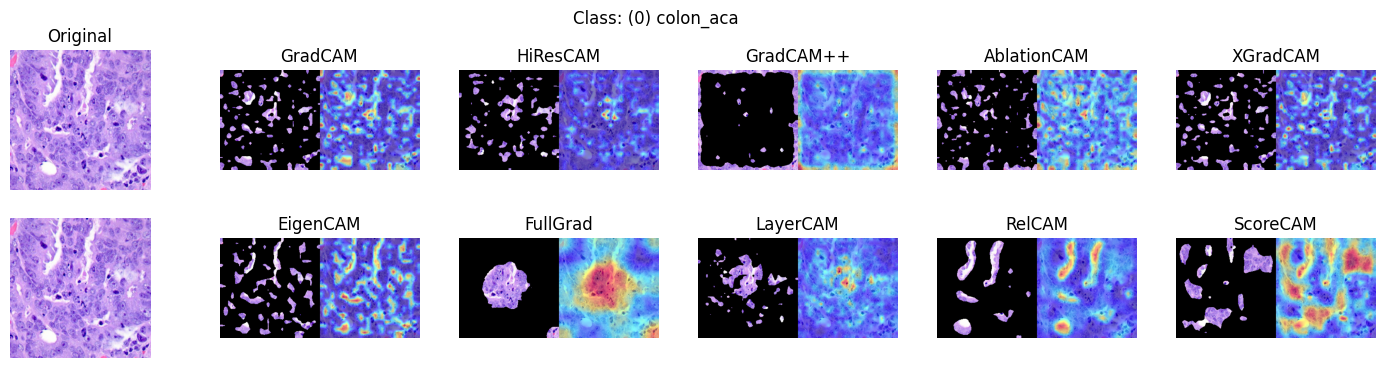

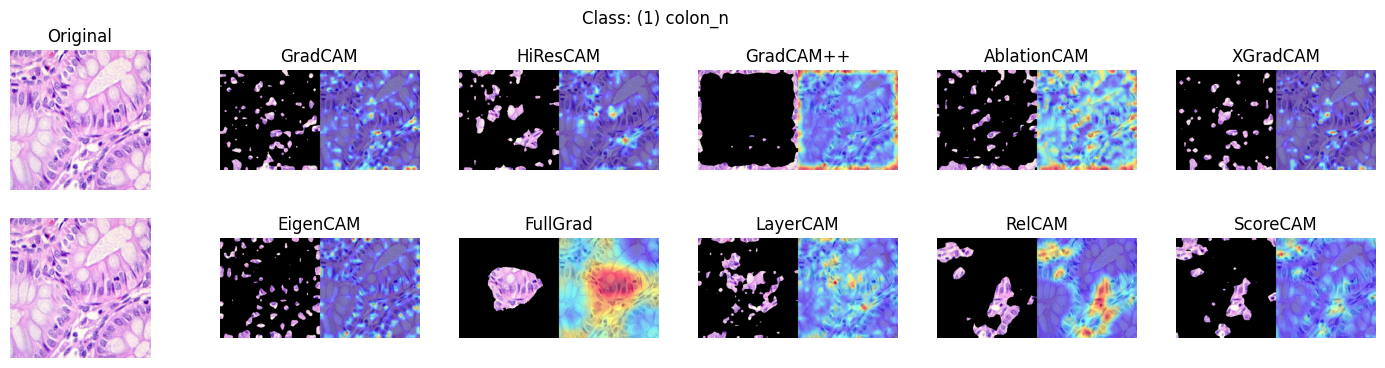

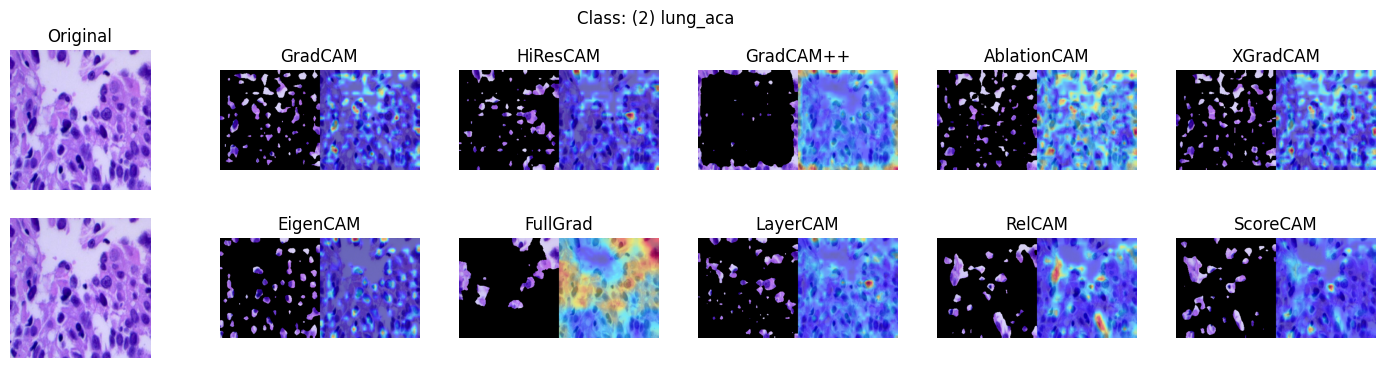

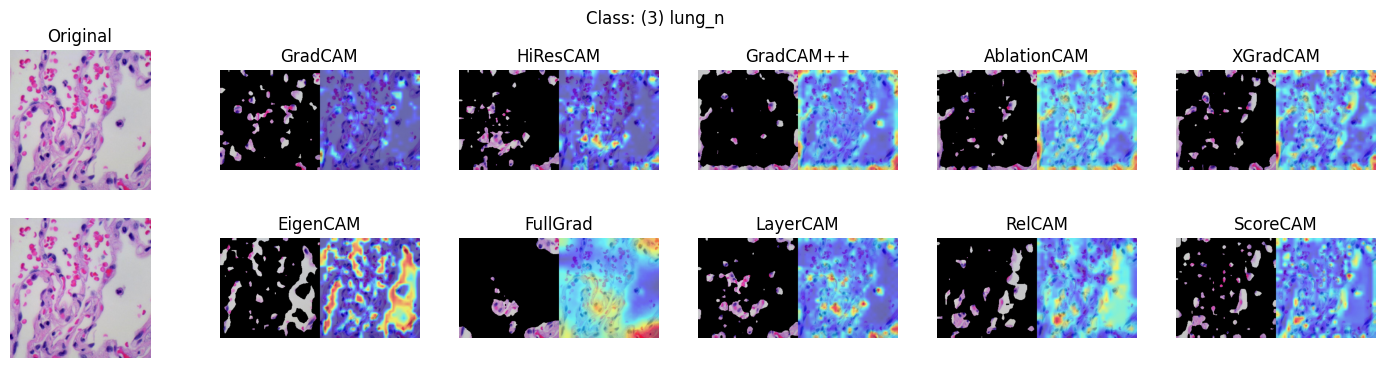

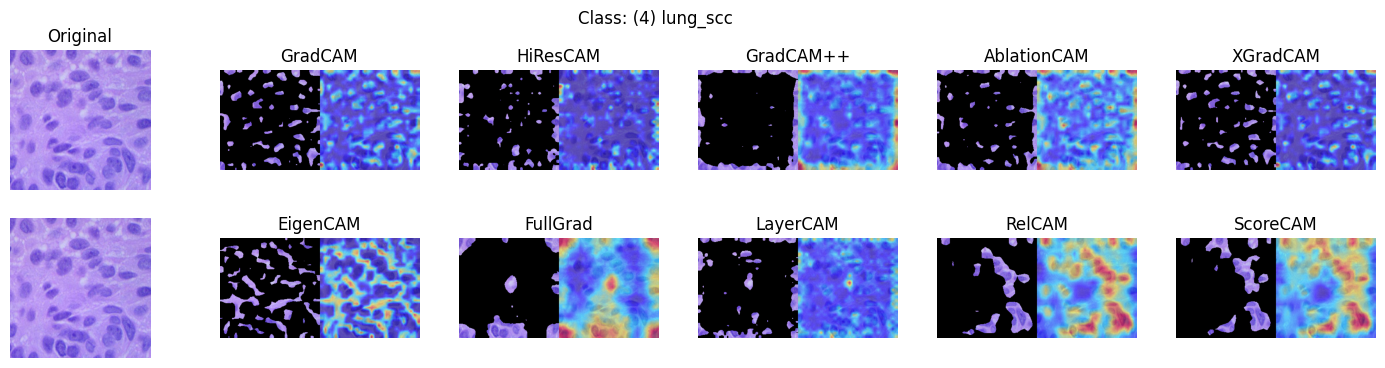

In [ ]:
for class_name in classes:
    ref_img, target_class, cam_imgs = results[class_name]
    # plot 12 images in 2 rows: first is original and 5 images from cams for each row
    fig, axs = plt.subplots(2, 6, figsize=(18, 4))
    fig.suptitle(f"Class: ({target_class}) {class_name}")
    axs[0, 0].imshow(ref_img)
    axs[0, 0].set_title("Original")
    axs[0, 0].axis('off')
    for i in range(1, 6):
        axs[0, i].imshow(cam_imgs[i-1][0])
        axs[0, i].set_title(f"{cam_imgs[i-1][1]}")
        axs[0, i].axis('off')
    axs[1, 0].imshow(ref_img)
    axs[1, 0].axis('off')
    for i in range(1, 6):
        axs[1, i].imshow(cam_imgs[i+4][0])
        axs[1, i].set_title(f"{cam_imgs[i+4][1]}")
        axs[1, i].axis('off')